In [1]:
import os

import numpy as np
import pandas as pd

import cv2 # opencv-python
from PIL import Image, ImageFont, ImageDraw
from tqdm import tqdm # 进度条

import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn.functional as F
from torchvision import models


D:\PYTHON\Anaconda\envs\biyesheji\lib\site-packages\torchvision\io\image.py:11: UserWarning: Failed to load image Python extension: Could not find module 'D:\PYTHON\Anaconda\envs\biyesheji\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.
  warn(f"Failed to load image Python extension: {e}")


In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('device:', device)


device: cuda:0


导入中文字体


In [3]:
font = ImageFont.truetype('simkai.ttf', 32)


载入类别


In [4]:
idx_to_labels = np.load('idx_to_labels.npy', allow_pickle=True).item()


In [5]:
idx_to_labels


{0: '乌鸦',
 1: '乌龟',
 2: '仓鼠',
 3: '企鹅',
 4: '兔子',
 5: '刺猬',
 6: '啄木鸟',
 7: '土狼',
 8: '大猩猩',
 9: '大象',
 10: '奶牛',
 11: '山羊',
 12: '斑马',
 13: '松鼠',
 14: '毛毛虫',
 15: '水母',
 16: '水獭',
 17: '河马',
 18: '浣熊',
 19: '海星',
 20: '海豚',
 21: '海豹',
 22: '海马',
 23: '火烈鸟',
 24: '火鸡',
 25: '熊',
 26: '熊猫',
 27: '牛',
 28: '牡蛎',
 29: '犀牛',
 30: '犀鸟',
 31: '狐狸',
 32: '狗',
 33: '狮子',
 34: '狼',
 35: '猩猩',
 36: '猪',
 37: '猫',
 38: '猫头鹰',
 39: '獾',
 40: '瓢虫',
 41: '甲虫',
 42: '章鱼',
 43: '羊',
 44: '羚羊',
 45: '老虎',
 46: '老鼠',
 47: '考拉',
 48: '苍蝇',
 49: '蚊子',
 50: '蚱蜢',
 51: '蛇',
 52: '蛾',
 53: '蜂鸟',
 54: '蜜蜂',
 55: '蜥蜴',
 56: '蜻蜓',
 57: '蝙蝠',
 58: '蝴蝶',
 59: '蟑螂',
 60: '蟹',
 61: '袋熊',
 62: '袋鼠',
 63: '豪猪',
 64: '豹',
 65: '负鼠',
 66: '野牛',
 67: '野猪',
 68: '金鱼',
 69: '霍加皮',
 70: '马',
 71: '驯鹿',
 72: '驴',
 73: '鬣狗',
 74: '鱿鱼',
 75: '鲨鱼',
 76: '鲸鱼',
 77: '鸭',
 78: '鸽子',
 79: '鹅',
 80: '鹈鹕',
 81: '鹦鹉',
 82: '鹬',
 83: '鹰',
 84: '鹿',
 85: '麻雀',
 86: '黑猩猩',
 87: '鼠',
 88: '龙虾'}

导入训练好的模型


In [6]:
model = torch.load('checkpoints/best-0.895.pth', map_location=torch.device('cpu'))
model = model.eval().to(device)


图像预处理


In [7]:
from torchvision import transforms

# 测试集图像预处理-RCTN：缩放裁剪、转 Tensor、归一化
test_transform = transforms.Compose([transforms.Resize(256),
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize(
                                         mean=[0.485, 0.456, 0.406],
                                         std=[0.229, 0.224, 0.225])
                                    ])


获取摄像头的一帧画面


In [8]:
# 导入opencv-python
import cv2
import time

# 获取摄像头，传入0表示获取系统默认摄像头
cap = cv2.VideoCapture(1)

# 打开cap
cap.open(0)

time.sleep(1)

success, img_bgr = cap.read()

# 关闭摄像头
cap.release()

# 关闭图像窗口
cv2.destroyAllWindows()


In [9]:
img_bgr.shape


(480, 640, 3)

In [10]:
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB) # BGR转RGB


In [11]:
img_pil = Image.fromarray(img_rgb)


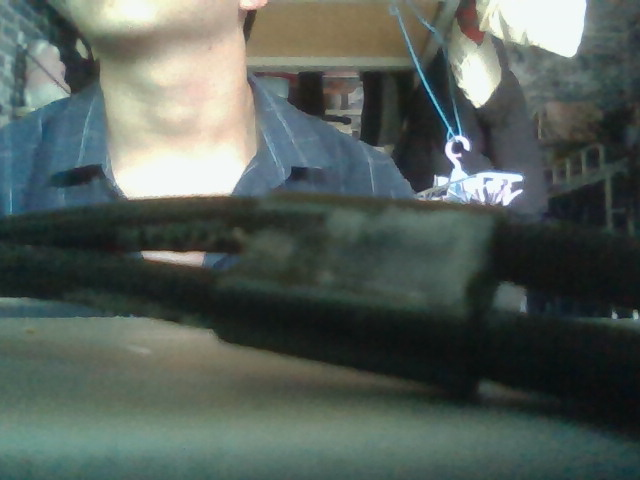

In [12]:
img_pil


In [13]:
input_img = test_transform(img_pil).unsqueeze(0).to(device) # 预处理
pred_logits = model(input_img) # 执行前向预测，得到所有类别的 logit 预测分数
pred_softmax = F.softmax(pred_logits, dim=1) # 对 logit 分数做 softmax 运算

n = 5
top_n = torch.topk(pred_softmax, n) # 取置信度最大的 n 个结果
pred_ids = top_n[1].cpu().detach().numpy().squeeze() # 解析出类别
confs = top_n[0].cpu().detach().numpy().squeeze() # 解析出置信度


In [14]:
draw = ImageDraw.Draw(img_pil)
# 在图像上写字
for i in range(len(confs)):
    pred_class = idx_to_labels[pred_ids[i]]
    text = '{:<15} {:>.3f}'.format(pred_class, confs[i])
    # 文字坐标，中文字符串，字体，rgba颜色
    draw.text((50, 100 + 50 * i), text, font=font, fill=(255, 0, 0, 1))
img = np.array(img_pil) # PIL 转 array


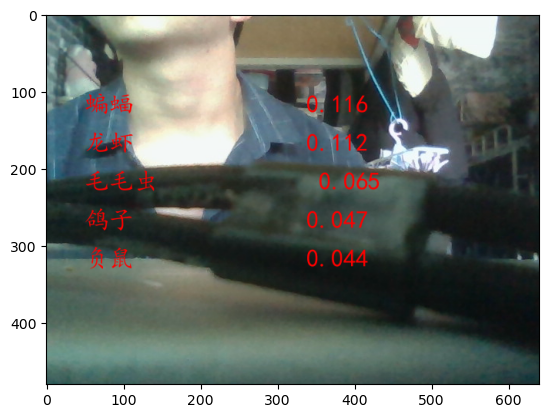

In [15]:
plt.imshow(img)
plt.show()


处理单帧画面的函数（中文）


In [16]:
# 处理帧函数
def process_frame(img):

    # 记录该帧开始处理的时间
    start_time = time.time()

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # BGR转RGB
    img_pil = Image.fromarray(img_rgb) # array 转 PIL
    input_img = test_transform(img_pil).unsqueeze(0).to(device) # 预处理
    pred_logits = model(input_img) # 执行前向预测，得到所有类别的 logit 预测分数
    pred_softmax = F.softmax(pred_logits, dim=1) # 对 logit 分数做 softmax 运算

    top_n = torch.topk(pred_softmax, 5) # 取置信度最大的 n 个结果
    pred_ids = top_n[1].cpu().detach().numpy().squeeze() # 解析预测类别
    confs = top_n[0].cpu().detach().numpy().squeeze() # 解析置信度

    # 使用PIL绘制中文
    draw = ImageDraw.Draw(img_pil)
    # 在图像上写字
    for i in range(len(confs)):
        pred_class = idx_to_labels[pred_ids[i]]
        text = '{:<15} {:>.3f}'.format(pred_class, confs[i])
        # 文字坐标，中文字符串，字体，bgra颜色
        draw.text((50, 100 + 50 * i),  text, font=font, fill=(255, 0, 0, 1))
    img = np.array(img_pil) # PIL 转 array
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) # RGB转BGR

    # 记录该帧处理完毕的时间
    end_time = time.time()
    # 计算每秒处理图像帧数FPS
    FPS = 1/(end_time - start_time)
    # 图片，添加的文字，左上角坐标，字体，字体大小，颜色，线宽，线型
    img = cv2.putText(img, 'FPS  '+str(int(FPS)), (50, 80), cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 0, 255), 4, cv2.LINE_AA)
    return img


调用摄像头获取每帧（模板）



In [17]:
# 调用摄像头逐帧实时处理模板
# 不需修改任何代码，只需修改process_frame函数即可
# 同济子豪兄 2021-7-8

# 导入opencv-python
import cv2
import time

# 获取摄像头，传入0表示获取系统默认摄像头
cap = cv2.VideoCapture(1)

# 打开cap
cap.open(0)

# 无限循环，直到break被触发
while cap.isOpened():
    # 获取画面
    success, frame = cap.read()
    if not success:
        print('Error')
        break

    ## !!!处理帧函数
    frame = process_frame(frame)

    # 展示处理后的三通道图像
    cv2.imshow('my_window',frame)

    if cv2.waitKey(1) in [ord('q'),27]: # 按键盘上的q或esc退出（在英文输入法下）
        break

# 关闭摄像头
cap.release()

# 关闭图像窗口
cv2.destroyAllWindows()
